In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fungsi masked loss
def masked_mse_loss(y_true, y_pred):
    mask = tf.not_equal(y_true, 0)  # Masker untuk nilai yang tidak nol (keypoint yang tersedia)
    mask = tf.cast(mask, tf.float32)  # Konversi ke float
    loss = tf.square(y_true - y_pred) * mask  # Hitung MSE hanya pada keypoint yang tersedia
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)  # Rata-rata loss berdasarkan jumlah keypoint yang tersedia
    return loss

model_path = './Assets/facial-keypoints-detection-model/facial_keypoints_detection_model.keras'
best_model = tf.keras.models.load_model(
    model_path,
    custom_objects={'masked_mse': masked_mse_loss}
)

In [3]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │      3,904 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │     73,856 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 12,    │      8,320 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 12, 12,    │          0 │ conv2d_5[0][0],   │
│                     │ 128)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18432)     │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1000)      │ 18,433,000 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │     30,030 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,262,692 (214.63 MB)

 Trainable params: 18,754,230 (71.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,508,462 (143.08 MB)

In [38]:
# Fungsi untuk membuat blok residual dengan konvolusi strided
def residual_block(x, filters):
    residual = x
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same', strides=2)(x)
    residual = tf.keras.layers.Conv2D(filters, (1, 1), padding='same', strides=2)(residual)
    x = tf.keras.layers.add([x, residual])
    return x

# Arsitektur ML-ResNet
def create_ml_resnet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Lapisan pertama
    x = tf.keras.layers.Conv2D(32, (11, 11), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Blok residual pertama
    x = residual_block(x, 64)

    # Blok residual kedua
    x = residual_block(x, 128)

    # Lapisan akhir
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(30)(x)  # 15 keypoints dengan masing-masing x dan y koordinat

    model = tf.keras.models.Model(inputs, x)
    return model

load_model=create_ml_resnet((96,96,1))
load_model.load_weights(model_path)

In [4]:
face_images_test_tf_dataset_loaded = tf.data.Dataset.load("./Assets/datasets/facial_keypoints_test_dataset.tfrecord", compression="GZIP")

In [5]:
print(f'info data: {face_images_test_tf_dataset_loaded}')
print(f'number of data: {len(face_images_test_tf_dataset_loaded)}')

info data: <_LoadDataset element_spec=TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None)>
number of data: 1783



    max-intensity: 0.9686274528503418
    min-intensity: 0.007843137718737125
    image-shape: (96, 96, 1)
    image-type: <dtype: 'float32'>
  


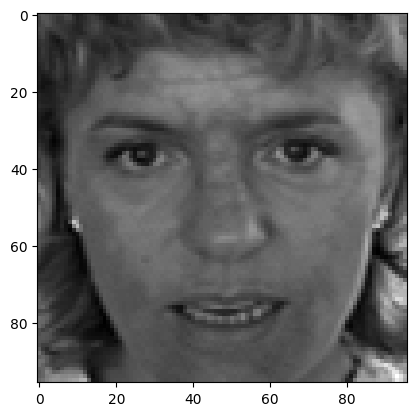

In [6]:
for img in face_images_test_tf_dataset_loaded.skip(1).take(1):
  print(f'''
    max-intensity: {tf.reduce_max(img)}
    min-intensity: {tf.reduce_min(img)}
    image-shape: {img.shape}
    image-type: {img.dtype}
  ''')
  plt.imshow(img, cmap='gray')
plt.show()

In [7]:
facial_keypoints_concatenated_test_dataset_batched = face_images_test_tf_dataset_loaded.batch(8)
facial_keypoints_concatenated_test_dataset_cached = facial_keypoints_concatenated_test_dataset_batched.cache()
facial_keypoints_concatenated_test_dataset_prefetched = facial_keypoints_concatenated_test_dataset_cached.prefetch(tf.data.AUTOTUNE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


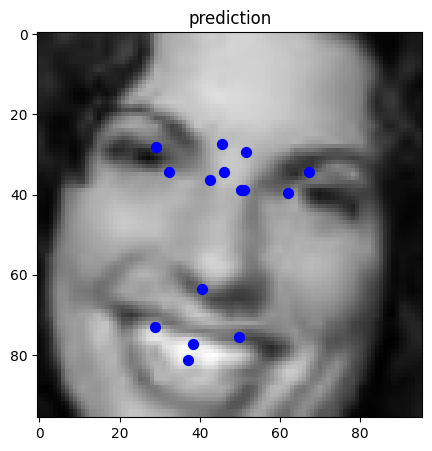

In [8]:
idx = np.random.randint(0, len(facial_keypoints_concatenated_test_dataset_prefetched))
plt.figure(figsize=(10,5))
for image in facial_keypoints_concatenated_test_dataset_prefetched.skip(idx).take(1):
  image = tf.expand_dims(image[0], axis=0)
  pred_keypoints = best_model.predict(image)
  pred_keypoints = tf.squeeze(pred_keypoints)

  plt.imshow(image[0], cmap='gray')
  for i in range(0, len(pred_keypoints), 2):
    x = pred_keypoints[i].numpy()
    y = pred_keypoints[i+1].numpy()
    plt.scatter(x, y, s=200, marker='.', c='blue')
  plt.title('prediction')

plt.show()